# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [2]:
import numpy as np
import imageio
import time
import matplotlib.pyplot as plt
from math import pi
%matplotlib inline

/tmp/ipykernel_5926/1561458680.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_5926/1561458680.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961
Size of the inflated map: (1000, 1000)
Occupied Cells: 847020
Free Cells: 152980


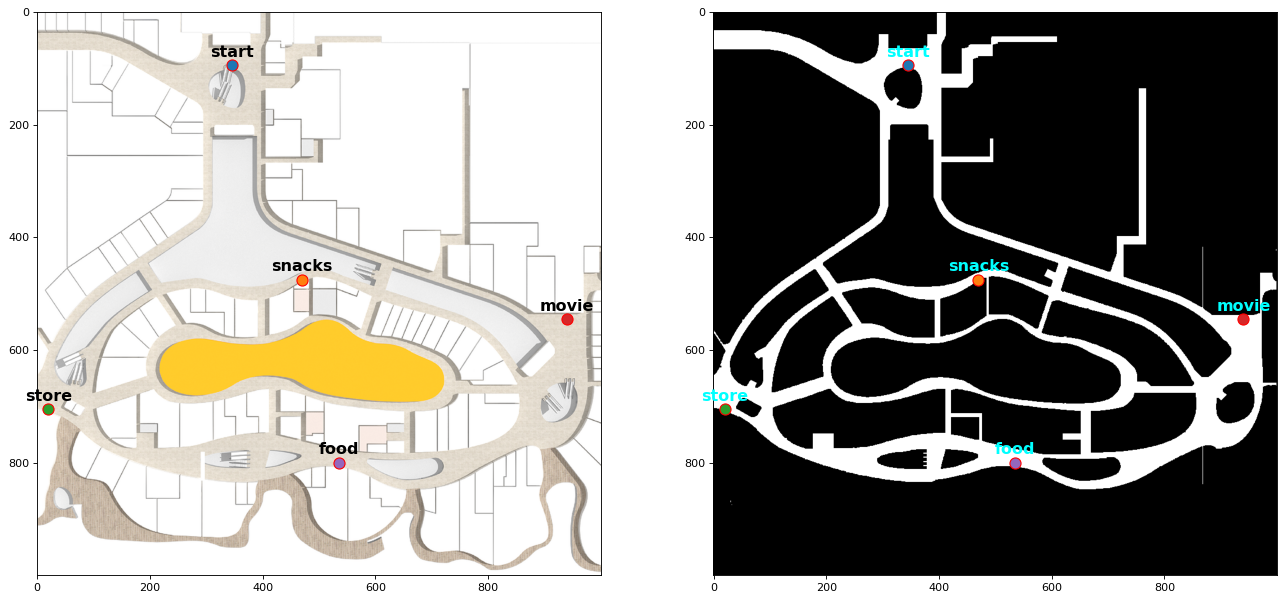

In [3]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map = imageio.imread('./map/vivocity_freespace.png')
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start': [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],  # Garrett Popcorn
             'store': [20, 705],    # DJI Store
             'movie': [940, 545],   # Golden Village
             'food': [535, 800],    # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Preoprocess the map
kernel = np.zeros((3, 3))  # 3x3 kernel for 8-connectivity
inflated_map = np.copy(grid_map)  # create a copy of the map

for i in range(1, len(grid_map)-1):
    for j in range(1, len(grid_map[0])-1):
        if grid_map[i, j] == 0:  # if the pixel is black
            inflated_map[i-1:i+2, j-1:j+2] = np.minimum(inflated_map[i-1:i+2, j-1:j+2], kernel)
inflated_map[0] = 0
inflated_map[:,0] = 0
inflated_map[len(grid_map)-1] = 0
inflated_map[:,len(grid_map)-1] = 0
print("Size of the inflated map:", inflated_map.shape)
print("Occupied Cells:", np.count_nonzero(inflated_map == 0))
print("Free Cells:", np.count_nonzero(inflated_map == 255))

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(inflated_map, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

## Task 1

* Initialize all planners and needed functions. 

Implemented planner: A*, Hybrid A*, Bidirectional A*, Switch A*, Dijkstra, Greedy best

In [4]:
class AstarPlanner:
    def __init__(self, map, resolution=0.2, connectivity=8, visualization = False):
        # Initialize the A* planner with a map, resolution, connectivity, and visualization flag
        self.grid_map = map
        self.resolution = resolution
        self.connectivity = connectivity
        self.visited = None
        self.visualization = visualization

    class node(object):
        def __init__(self, state, g_cost, h_cost, parent):
            # A class to represent a node in the A* algorithm
            self.state = state
            self.g_cost = g_cost
            self.h_cost = h_cost
            self.parent = parent

    def manhatten_distance(self, p1, p2):
        # Calculate the Manhattan distance between two points
        return abs(p1[0]- p2[0]) + abs(p1[1]- p2[1])
    
    def calculate_g(self, p1, p2):
        # Calculate the cost to move from p1 to p2
        return self.neighboring_distance(p1, p2)

    def calculate_h(self, current, goal):
        # Calculate the heuristic cost from current to goal
        return self.manhatten_distance(current, goal)

    def euclidean_distance(self, p1, p2):
        # Calculate the Euclidean distance between two points
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    def neighboring_distance(self, p1, p2):
        # Calculate the cost to move from p1 to p2 in a diagonal direction
        if p1[0] == p2[0] or p1[1] == p2[1]:
            return 1
        else:
            return 1.414

    def is_valid_point(self, point):
        # Check if a point is valid (within the map and not an obstacle)
        x, y = point
        return 0 <= x < self.grid_map.shape[1] and 0 <= y < self.grid_map.shape[0] and self.grid_map[y, x] == 255

    def plan(self, start, end):
        # Plan a path from start to end using A*
        self.visited = set()  # Keep track of visited nodes
        start_node = self.node(start, 0, self.manhatten_distance(start, end), None)  # Create a starting node with initial values
        open_list = [start_node]  # Keep a list of nodes to visit
        if self.visualization:
            # Visualize the map, start, and end points
            plt.imshow(self.grid_map, cmap='gray')
            plt.plot(start[0], start[1], 'ro')
            plt.plot(end[0], end[1], 'go')
            plt.axis('off')
            plt.tight_layout()
        start_time = time.time()
        while open_list:
            # Select the node with the lowest f_cost from the open list
            current = min(open_list, key=lambda x: x.g_cost + x.h_cost)
            open_list.remove(current)
            if current.state == end:
                # If the goal has been reached, construct the path and return it
                print(f"Path found between {start} and {end}.")
                path = [end]
                while current.parent:
                    path.append(current.parent.state)
                    current = current.parent
                path.reverse()
                return path, self.visited, time.time() - start_time
            # Add current node to visited
            self.visited.add(current.state)
            if self.visualization:
                # Visualize the current node
                plt.plot(current.state[0], current.state[1], "ro")
            # Find the neighbors of the current node
            neighbors = [(current.state[0] + dx, current.state[1] + dy) for dx in range(-1, 2) for dy in range(-1, 2) if dx != 0 or dy != 0]
            if self.connectivity == 4:
                # Limit neighbors to four-connectivity if desired
                neighbors = [(x, y) for x, y in neighbors if abs(x - current.state[0]) + abs(y - current.state[1]) <= 1]
            for neighbor in neighbors:
                if self.is_valid_point(neighbor) and neighbor not in self.visited:
                    # Calculate the cost of moving to the neighbor
                    g = current.g_cost + self.calculate_g(neighbor, current.state)
                    in_open_list = False
                    for node_in_list in open_list:
                        if node_in_list.state == neighbor:
                            in_open_list = True
                            if g < node_in_list.g_cost:
                                # Update the cost of the neighbor if it is in the open list and the new cost is lower
                                node_in_list.g_cost = g
                                node_in_list.parent = current
                            break
                    if not in_open_list:
                        # Add the neighbor to the open list if it is not already there
                        h = self.calculate_h(neighbor, end)
                        neighbor_node = self.node(neighbor, g, h, current)
                        open_list.append(neighbor_node)
                        if self.visualization:
                            plt.plot(neighbor_node.state[0], neighbor_node.state[1], "bo")
            if self.visualization:
                plt.pause(0.001)
        # If there is no path, return None
        return None, self.visited, 0
    
class hybridAstarPlanner(AstarPlanner):
    def __init__(self, map, connectivity=None, resolution=0.2, max_steering=pi/4, num_steps=20, visualization=False):
        # Call the constructor of the base class (AstarPlanner)
        super().__init__(map, resolution, visualization=visualization)
        # Set the weight for curvature-based cost
        self.curvature_weight = 0.2
        # Set the maximum steering angle for the car
        self.max_steering = max_steering
        # Set the number of steps for the trajectory
        self.num_steps = num_steps
    
    class hybrid_node(object):
        def __init__(self, state, x_list, y_list, yaw_list, g_cost, h_cost, parent):
            # Store the state of the hybrid node (x, y, theta)
            self.state = state
            # Store the list of x, y, and yaw values for the trajectory
            self.x_list = x_list
            self.y_list = y_list
            self.yaw_list = yaw_list
            # Store the g-cost and h-cost values of the hybrid node
            self.g_cost = g_cost
            self.h_cost = h_cost
            # Store a reference to the parent hybrid node
            self.parent = parent

    def calculate_h(self, current, goal):
        # Use Euclidean distance as the heuristic for A*
        return self.euclidean_distance(current, goal)

    def generate_trajectory(self, x, y, theta, steer, v):
        # Calculate the time step based on the current velocity
        dt = 0.3 / v
        # Initialize the trajectory with the current state
        traj = [(x, y, theta)]
        # Initialize the length of the trajectory to zero
        traj_length = 0
        # Generate a trajectory with a fixed number of steps
        for i in range(self.num_steps):
            # Stop generating the trajectory if the length is greater than 1.4 meters
            if traj_length > 1.4:
                break
            # Update the angle based on the steering angle and time step
            theta += steer * dt
            # Update the x and y positions based on the angle, velocity, and time step
            x += v * np.cos(theta) * dt
            y += v * np.sin(theta) * dt
            # Update the length of the trajectory
            traj_length += v * dt
            # Add the new state to the trajectory
            traj.append([x, y, theta])
        # Return the trajectory
        return traj

    def is_valid_hybrid_node(self, x, y):
        # Check if the point (x, y) is valid (i.e., not occupied by an obstacle)
        return self.is_valid_point((int(round(x)), int(round(y))))

    def car_cost(self, p1, p2):
        # Unpack x, y, and theta from each point
        x1, y1, theta1 = p1
        x2, y2, theta2 = p2
        # Calculate steering angle
        steer = np.arctan2(y2 - y1, x2 - x1) - theta1
        # Generate trajectory based on steering angle and velocity
        traj = self.generate_trajectory(x1, y1, theta1, steer, 1.0)
        # Initialize cost to zero
        cost = 0
        # Iterate over each segment in the trajectory
        for i in range(len(traj) - 2):
            # Get points for current segment, next segment, and segment after that
            p1 = traj[i]
            p2 = traj[i + 1]
            p3 = traj[i + 2]
            # Calculate curvature using finite differences
            dx1 = p1[0] - p2[0]
            dy1 = p1[1] - p2[1]
            dx2 = p2[0] - p3[0]
            dy2 = p2[1] - p3[1]
            if abs(dx1) < 1e-6 and abs(dy1) < 1e-6:
                k1 = 0
            else:
                k1 = 2 * (dx1 * dy2 - dy1 * dx2) / (dx1 ** 2 + dy1 ** 2) ** 1.5
            # Add the distance between the current and next point and the curvature-based cost to the total cost
            cost += 0.2*self.neighboring_distance((int(round(p1[0])), int(round(p1[1]))),
                                            (int(round(p2[0])), int(round(p2[1])))) + abs(k1) * self.curvature_weight
        # Return the total cost
        return cost


    def plan(self, start, end):
        # Initialize the visited set
        self.visited = set()

        # Calculate the initial orientation
        initial_orientation = np.arctan2(end[1] - start[1], end[0] - start[0])

        # Create the start node
        start_node = self.hybrid_node((start[0], start[1], int(round(initial_orientation / (pi/12)))*pi/12), [start[0]], [start[1]], [initial_orientation], 0, self.manhatten_distance(start, end), None)

        # Add the start node to the open list
        open_list = [start_node]

        # If visualization is enabled, plot the start and end points on the grid map
        if self.visualization:
            plt.imshow(self.grid_map, cmap='gray')
            plt.plot(start[0], start[1], 'ro', zorder=100)
            plt.plot(end[0], end[1], 'go')
            plt.axis('off')
            plt.tight_layout()

        # Record the starting time
        start_time = time.time()

        # Loop until the open list is empty
        while open_list:
            # Select the node with the lowest f-cost from the open list
            current = min(open_list, key=lambda x: x.g_cost + x.h_cost)

            # Remove the current node from the open list
            open_list.remove(current)

            # If the current node is at the goal, return the path
            if current.state[0:2] == end:
                print(f"Path found between {start} and {end}.")
                path = [end]

                # Follow the parent pointers to build the path
                while current.parent:
                    path.append(current.parent.state[0:2])
                    current = current.parent
                path.reverse()
                return path, self.visited, time.time()-start_time

            # Add the current node to the visited set
            self.visited.add(current)

            # If visualization is enabled, plot the current node on the grid map
            if self.visualization:
                plt.plot(current.state[0], current.state[1], "ro", zorder=100)

            # Generate trajectories for each possible steering angle
            for steer in [0, -self.max_steering*0.5, self.max_steering*0.5, -self.max_steering, self.max_steering]:
                traj = self.generate_trajectory(current.x_list[-1], current.y_list[-1], current.yaw_list[-1], steer, 1.0)

                # Loop through the states along the trajectory
                for i in range(len(traj)):
                    # Create the next state
                    next_state = (int(round(traj[i][0])), int(round(traj[i][1])), int(round(traj[i][2] / (pi/12)))*pi/12)

                    # Initialize the flag variable to check if the next node is already in the open list or visited set
                    FLAG = False

                    # If the next state is not valid, skip it
                    if not self.is_valid_hybrid_node(next_state[0], next_state[1]):
                        continue

                    # Calculate the g-cost and h-cost of the next node
                    next_g_cost = current.g_cost + self.car_cost(traj[0], traj[i])
                    next_h_cost = self.calculate_h(next_state[0:2], end)

                    # Create the next node
                    next_node = self.hybrid_node(next_state, np.array(traj)[:i,0], np.array(traj)[:i,1], np.array(traj)[:,2], next_g_cost, next_h_cost, current)
                    
                    # Check if already exist in open_list to accelerate
                    for node in open_list:
                        if node.state[0:2] == next_state[0:2]:
                            FLAG = True
                            break
                    if FLAG:
                        continue

                    for node in self.visited:
                        if node.state[0:2] == next_state[0:2]:
                            FLAG = True
                            break
                    if FLAG:
                        continue
                    open_list.append(next_node)

                    if self.visualization:
                        plt.plot(next_node.state[0], next_node.state[1], "bo")
                    if self.visualization:
                        plt.plot(np.array(traj)[:,0], np.array(traj)[:,1], "yo", markersize=3)
            if self.visualization:
                plt.pause(0.001)
            if time.time()-start_time >= 90:
                print(f"Run out of time, no path between {start} and {end} found.")
                break
        return None, self.visited, 0
    
class bidirectionalAstarPlanner(AstarPlanner):
    def __init__(self, map, connectivity, visualization):
        super().__init__(map, connectivity=connectivity, visualization=visualization)
        self.visited_forward = None
        self.visited_backward = None

    def _merge_paths(self, current_forward, concatenated_node):
        """
        Merge the paths found from the two searches.

        Args:
            current_forward (node): Latest node from the forward search.
            concatenated_node (node): Node to be concatenated.

        Returns:
            list: The combined path from start to goal.
            goal: the state of the goal.
        """
        path = [current_forward.state]
        while current_forward.parent:
            current_forward = current_forward.parent
            path.insert(0, current_forward.state)
        current_backward = concatenated_node
        while current_backward.parent:
            current_backward = current_backward.parent
            path.append(current_backward.state)
        return path

    def plan(self, start, end):
        start_node = self.node(start, 0, self.manhatten_distance(start, end), None)
        end_node = self.node(end, 0, self.manhatten_distance(end, start), None)
        self.visited_forward = set()
        self.visited_backward = set()
        self.visitedNode_backward = []
        open_list_forward = [start_node]
        open_list_backward = [end_node]
        if self.visualization:
            plt.imshow(self.grid_map, cmap='gray')
            plt.plot(start[0], start[1], 'ro')
            plt.plot(end[0], end[1], 'go')
            plt.axis('off')
            plt.tight_layout()
        start_time = time.time()
        while open_list_forward and open_list_backward:
            current_forward = min(open_list_forward, key=lambda x: x.g_cost + x.h_cost)
            current_backward = min(open_list_backward, key=lambda x: x.g_cost + x.h_cost)
            for state in self.visited_backward:
                if current_forward.state == state:
                    # path found
                    print(f"Path found between {start} and {end}.")
                    for n in self.visitedNode_backward:
                        if n.state == state:
                            node = n
                    if node.parent is None: # Forwarding directly to the end
                        path = [current_forward.state]
                        while current_forward.parent:
                            path.append(current_forward.parent.state)
                            current_forward = current_forward.parent
                        path.reverse()
                        return path, self.visited_forward.union(self.visited_backward), time.time() - start_time
                    
                    if node.state == start: # Backwarding directly to the start
                        path = [current_backward.state]
                        while current_backward.parent:
                            path.append(current_backward.parent.state)
                            current_backward = current_backward.parent
                        path.reverse()
                        return path, self.visited_forward.union(self.visited_backward), time.time() - start_time
                    
                    concatenated_node = node.parent
                    path = self._merge_paths(current_forward, concatenated_node)
                    return path, self.visited_forward.union(self.visited_backward), time.time()-start_time
                
            open_list_forward.remove(current_forward)
            open_list_backward.remove(current_backward)
            self.visited_forward.add(current_forward.state)
            self.visited_backward.add(current_backward.state)
            self.visitedNode_backward.append(current_backward)
            if self.visualization:
                plt.plot(current_forward.state[0], current_forward.state[1], "ro")
                plt.plot(current_backward.state[0], current_backward.state[1], "ro")

            neighbors_f = [(current_forward.state[0] + dx, current_forward.state[1] + dy) for dx in range(-1, 2) for dy in range(-1, 2) if dx != 0 or dy != 0]
            neighbors_b = [(current_backward.state[0] + dx, current_backward.state[1] + dy) for dx in range(-1, 2) for dy in range(-1, 2) if dx != 0 or dy != 0]

            if self.connectivity == 4:
                # Get neighbors that are within 4-connectivity distance
                neighbors_f = [(x, y) for x, y in neighbors_f if abs(x - current_forward.state[0]) + abs(y - current_forward.state[1]) <= 1]
                neighbors_b = [(x, y) for x, y in neighbors_b if abs(x - current_backward.state[0]) + abs(y - current_backward.state[1]) <= 1]

            # Check neighbors and update path
            for neighbor in neighbors_f:
                if self.is_valid_point(neighbor) and neighbor not in self.visited_forward:
                    # Calculate g-value, the cost from the start node to neighbor
                    g = current_forward.g_cost + self.calculate_g(neighbor, current_forward.state)
                    # Check if the neighbor is already in the open list
                    in_open_list = False
                    for node_in_list in open_list_forward:
                        if node_in_list.state == neighbor:
                            in_open_list = True
                            # Update g-value and parent node if the neighbor is already in the open list
                            if g < node_in_list.g_cost:
                                node_in_list.g_cost = g
                                node_in_list.parent = current_forward
                            break
                    # If neighbor is not in the open list, add it to the open list
                    if not in_open_list:
                        h = self.calculate_h(neighbor, end) # Calculate h-value, the estimated cost from the neighbor to the goal node
                        neighbor_node = self.node(neighbor, g, h, current_forward) # Create a node for the neighbor
                        open_list_forward.append(neighbor_node)

                        if self.visualization:
                            plt.plot(neighbor_node.state[0], neighbor_node.state[1], "bo")

            for neighbor in neighbors_b:
                if self.is_valid_point(neighbor) and neighbor not in self.visited_backward:
                    g = current_backward.g_cost + self.calculate_g(neighbor, current_backward.state)
                    in_open_list = False
                    for node_in_list in open_list_backward:
                        if node_in_list.state == neighbor:
                            in_open_list = True
                            if g < node_in_list.g_cost:
                                node_in_list.g_cost = g
                                node_in_list.parent = current_backward
                            break
                    if not in_open_list:
                        h = self.calculate_h(neighbor, start)
                        neighbor_node = self.node(neighbor, g, h, current_backward)
                        open_list_backward.append(neighbor_node)

                        if self.visualization:
                            plt.plot(neighbor_node.state[0], neighbor_node.state[1], "bo")
            # Check if the algorithm has run for more than 90 seconds
            if time.time()-start_time >= 90:
                print(f"Run out of time, no path between {start} and {end} found.")
                break
            if self.visualization:
                plt.pause(0.001)

        # If there is no path found within the time limit, return None
        return None, self.visited_forward.union(self.visited_backward), 0


    
class switchAstarPlanner(AstarPlanner):
    def __init__(self, map, connectivity, visualization):
        super().__init__(map, connectivity=connectivity, visualization=visualization)

    def calc_pathLength(self, path):
        path_length = 0
        for n in range(len(path)):
            if n == len(path)-1:
                break
            path_length += self.neighboring_distance(path[n], path[n+1]) * self.resolution
        return path_length
    
    def plan(self, start, end):
        planner = AstarPlanner(self.grid_map, connectivity=self.connectivity, visualization=self.visualization)
        path, visited, time = planner.plan(start, end)
        path_reverse, visited_reverse, time_reverse = planner.plan(end, start)
        if path is not None:
            l_forward = self.calc_pathLength(path)
            l_reverse = self.calc_pathLength(path_reverse)
        if l_forward > l_reverse:
            return path_reverse, visited_reverse, time + time_reverse
        else:
            return path, visited, time + time_reverse
        
class DijkstraPlanner(AstarPlanner):
    def __init__(self, map, connectivity, visualization):
        super().__init__(map, connectivity=connectivity, visualization=visualization)

    def calculate_h(self, current, goal):
        return 0
    
class greedyPlanner(AstarPlanner):
    def __init__(self, map, connectivity, visualization):
        super().__init__(map, connectivity=connectivity, visualization=visualization)

    def calculate_g(self, p1, p2):
        return 0
    
def calc_pathLength(path, planner, resolution=0.2):
    path_length = 0
    for n in range(len(path)):
        if n == len(path)-1:
            break
        path_length += planner.euclidean_distance(path[n], path[n+1]) * resolution
    return path_length

def plan_all_paths(points, planner):
    # Initialize variables to keep track of success rate, paths, visited cells, time, distances, and count
    success = 0
    paths = []
    visited_cells_list = []
    total_time = 0
    distances_total = []
    count = 0
    
    # Loop through all pairs of points in the list
    for i in range(len(points)):
        distances = []
        for j in range(len(points)):
            # If the start and end points are the same, the distance is 0
            if i == j:
                distances.append(0)
                continue
            visited_cells = set()
            # Plan a path from the current start and end points using the provided planner object
            path, visited, time = planner.plan(points[i], points[j])
            # If a path is found, update the success rate and add the path to the list of paths
            if path is not None:
                success += 1
                # Calculate the length of the path and add it to the distances list
                path_length = calc_pathLength(path, planner)
                distances.append(round(path_length, 2))
            # If no path is found, add a dash to the distances list to indicate failure
            else:
                count -= 1
                distances.append('-')

            # Update the total time and count variables
            total_time += time
            paths.append(path)
            visited_cells.update(visited)
            count += 1
        visited_cells_list.append(visited_cells)
        distances_total.append(distances)

    # Calculate the average time and average length of successful paths
    avg_time = total_time/count
    total = 0
    c = 0
    for row in distances_total:
        for elem in row:
            if elem != '-' and elem != 0:
                total += elem
                c += 1
    if c == 0:
        average_length = 0
    else:
        average_length = total / c

    # Calculate the success rate and return the paths, distances, visited cells, average time, average length, and success rate
    success_rate = success/(len(points)**2-len(points))
    return paths, distances_total, visited_cells_list, avg_time, average_length, success_rate





def visPath(locations_dict, paths, grid_map):
    # Visualize the map and paths
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(grid_map, cmap='gray')

    for key, value in locations_dict.items():
        plt.plot(locations_dict[key][0], locations_dict[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations_dict[key][0], locations_dict[key][1]-15, s=key, fontsize='x-large', fontweight='bold', color='b', ha='center')

    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, path in enumerate(paths):
        if path is not None:
            color=colors[i % len(colors)]
            # extract x and y coordinates
            x_coords = [p[0] for p in path]
            y_coords = [p[1] for p in path]
            # calculate arrow directions
            dx = [path[i+1][0] - path[i][0] for i in range(len(path)-1)]
            dy = [path[i+1][1] - path[i][1] for i in range(len(path)-1)]
            ax.quiver(x_coords[:-1:20], y_coords[:-1:20], dx[::20], dy[::20], angles='xy', scale_units='xy', width = 0.005, scale=1, color = color, zorder = 10)
            path_array = np.array(path)
            ax.plot(path_array[:,0], path_array[:,1], color=color, linewidth=2, alpha=0.7)

    ax.set_title('Occupancy Grid Map')
    plt.show()

* Begin planning

Path found between (345, 95) and (470, 475).
Path found between (345, 95) and (20, 705).
Path found between (345, 95) and (940, 545).
Path found between (345, 95) and (535, 800).
Path found between (470, 475) and (345, 95).
Path found between (470, 475) and (20, 705).
Path found between (470, 475) and (940, 545).
Path found between (470, 475) and (535, 800).
Path found between (20, 705) and (345, 95).
Path found between (20, 705) and (470, 475).
Path found between (20, 705) and (940, 545).
Path found between (20, 705) and (535, 800).
Path found between (940, 545) and (345, 95).
Path found between (940, 545) and (470, 475).
Path found between (940, 545) and (20, 705).
Path found between (940, 545) and (535, 800).
Path found between (535, 800) and (345, 95).
Path found between (535, 800) and (470, 475).
Path found between (535, 800) and (20, 705).
Path found between (535, 800) and (940, 545).
distance list: [[0, 142.45, 155.13, 178.89, 223.32], [142.49, 0, 118.59, 107.51, 133.43], [156.7

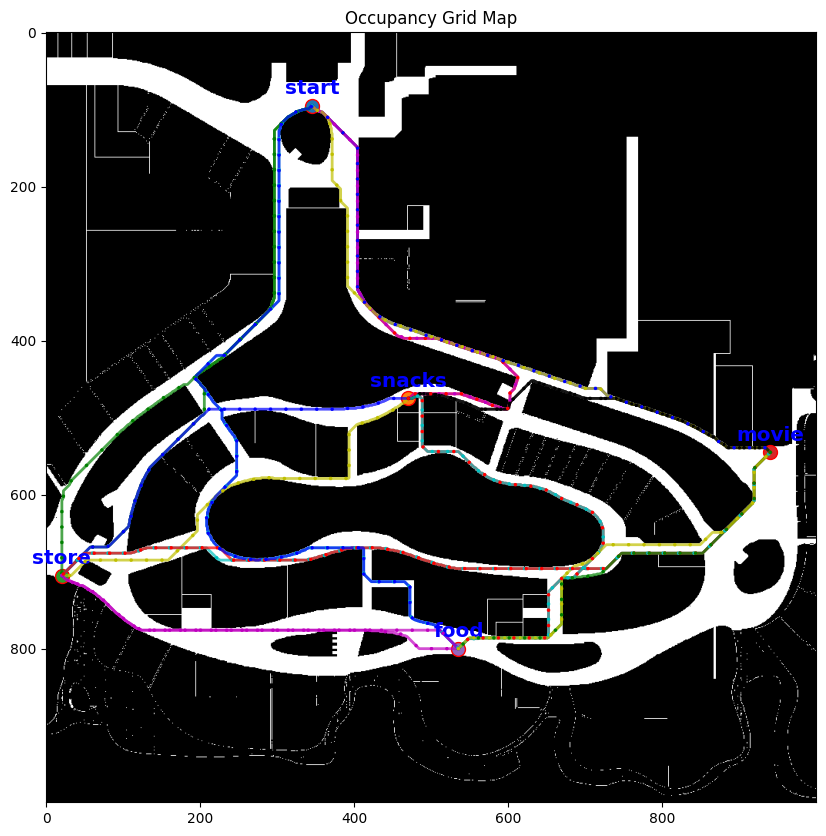

In [5]:
points = [tuple(value) for value in locations.values()]

 # Change the planner here. Implemented planner: AstarPlanner, hybridAstarPlanner, bidirectionalAstarPlanner, switchAstarPlanner,
 # DijkstraPlanner, greedyPlanner
planner = bidirectionalAstarPlanner(inflated_map, connectivity=8, visualization=False)
# points = [points[0], points[2]]
paths, distances_total, visited_cells, avg_time, avg_distance, success_rate = plan_all_paths(points, planner)

print(f"distance list: {distances_total}")
print(f"Avg time consumed: {round(avg_time, 2)}")
print(f"Avg length of path: {round(avg_distance, 2)}")
print(f"Success rate: {100*round(success_rate, 2)}%")

# Visualize the map and paths
visPath(locations, paths, grid_map)

## Task 3

* Initialize all needed functions.

In [6]:
import itertools

def nearest_neighbor(dist, visited):
    min_dist = float('inf')
    next_node = -1
    for i in range(dist.shape[0]):
        if i not in visited and dist[visited[-1], i] < min_dist:
            min_dist = dist[visited[-1], i]
            next_node = i
    return next_node


def TSP(paths, distances, method='nearestNeighbor'):
    # Starting point
    start = 0

    if method == 'nearestNeighbor':
        # Visited nodes
        visited = [start]

        # Find nearest neighbor until all nodes are visited
        while len(visited) < distances.shape[0]:
            next_node = nearest_neighbor(distances, visited)
            visited.append(next_node)

        # Add starting point to the end to complete the loop
        visited.append(start)

        # Print the optimal route and total distance
        print("Optimal route: ", visited)

        # Define a dictionary to map integers to store names
        store_names = {1: 'Snacks', 2: 'Store', 3: 'Movie', 4: 'Food', 0: 'Start'}

        # Process the optimal route to replace integers with store names
        optimal_route_names = [store_names[i] for i in visited]

        # Print the final shortest route on the map, and the total distance
        print(" -> ".join(optimal_route_names) + "")
        print("Total distance: ", sum([distances[visited[i], visited[i+1]] for i in range(len(visited)-1)]))

        path2d = np.zeros((5, 5)).tolist()
        index = 0
        for i in range(5):
            for j in range(5):
                if i != j:
                    path2d[i][j] = paths[index]
                    index += 1
        optimalRoute = []
        for i in range(len(visited)):
            if i != len(visited)-1:
                optimalRoute.append(path2d[visited[i]][visited[i+1]])
        return optimalRoute
    
    elif method == 'bruteForce':
        num_stores = distances.shape[0] - 1 # Excluding the start point
        store_indices = list(range(1, num_stores+1)) # Indices of stores in the distances matrix

        # Generate all possible permutations of store indices
        permutations = list(itertools.permutations(store_indices))

        # Add start and end indices to each permutation to complete the loop
        all_routes = [[0] + list(p) + [0] for p in permutations]

        # Calculate the total distance for each route
        route_distances = [sum([distances[r[i], r[i+1]] for i in range(len(r)-1)]) for r in all_routes]

        # Find the index of the route with the minimum distance
        min_distance_index = route_distances.index(min(route_distances))

        # Get the optimal route
        optimalRoute = all_routes[min_distance_index]

        # Print the optimal route and total distance
        print("Optimal route: ", optimalRoute)

        # Define a dictionary to map integers to store names
        store_names = {1: 'Snacks', 2: 'Store', 3: 'Movie', 4: 'Food', 0: 'Start'}

        # Process the optimal route to replace integers with store names
        optimal_route_names = [store_names[i] for i in optimalRoute]

        # Print the final shortest route on the map, and the total distance
        print(" -> ".join(optimal_route_names) + "")
        print("Total distance: ", min(route_distances))

        path2d = np.zeros((5, 5)).tolist()
        index = 0
        for i in range(5):
            for j in range(5):
                if i != j:
                    path2d[i][j] = paths[index]
                    index += 1
        optimalRoute2d = []
        for i in range(len(optimalRoute)):
            if i != len(optimalRoute)-1:
                optimalRoute2d.append(path2d[optimalRoute[i]][optimalRoute[i+1]])
        return optimalRoute2d
    

* Begin solving traveling seller problem

Optimal route:  [0, 1, 3, 4, 2, 0]
Start -> Snacks -> Movie -> Food -> Store -> Start
Total distance:  631.59


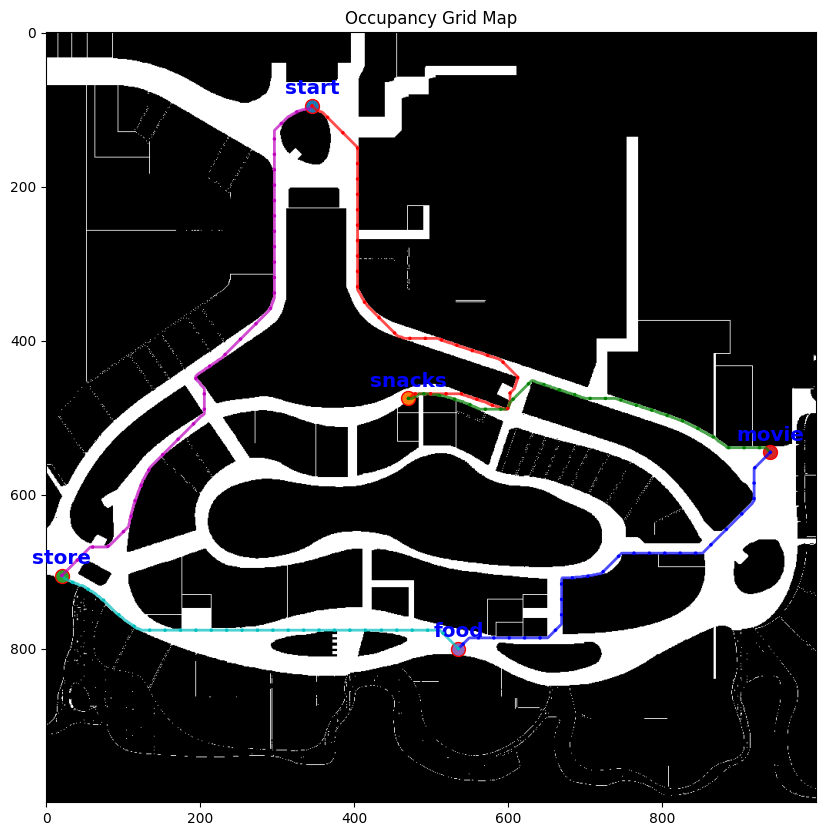

In [8]:
# Distance matrix
distances = np.array(distances_total)

optimalRoute = TSP(paths, distances, 'nearestNeighbor') # Options: 'bruteForce', 'nearestNeighbor'

visPath(locations, optimalRoute, grid_map)